<a href="https://colab.research.google.com/github/valid999/Reinforcement_project-/blob/main/Reinforment_learning(DQN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%bash
pip3 install gymnasium[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 13.6 MB/s eta 0:00:00


In [3]:
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
import matplotlib
from collections import namedtuple , deque
from itertools import count



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make('CartPole-v1')


# Set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display

plt.ion()

# If GPU is to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### **ReplyMemory** : a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a .sample() method for selecting a random batch of transitions for training.

In [4]:
Transition = namedtuple('Transition' ,    # transition maped the state , action to the next_state , reward
                        ('state' , 'action' , 'next_state','reward'))

class ReplyMemory(object):


  def __init__(self , capacity):
    self.memory = deque([] , maxlen = capacity)


  def push(self , *args):
    'Save a transition'
    self.memory.append(Transition(*args))

  def sample(self , batch_size):
    return random.sample(self.memory , batch_size)


  def __len__(self):
    return len(self.memory)


## The model architecture is Q network method:
Q(s , left) and Q(s , right) (Where s is input to the nwtwork)
In effect the nedtwork is trying to predict the expected return of taking each action given input .

In [5]:
class DQN(nn.Module):

  def __init__(self , n_observations , n_actions):
    super(DQN , self).__init__()
    self.layer1 = nn.Linear( n_observations, 128) # n_observations the number of the state
    self.layer2 = nn.Linear(128 , 128)
    self.layer3 = nn.Linear(128 , n_actions)




  # Called with either one element to determine next action or a batch
  # During optimization . Returns tensor([[Left0exp , right0exp]...])
  def forward(self , x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    return self.layer3(x)


In [13]:
# Batch size is the number of the transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START  the starting value of the epsilon
# EPS_END is the final value of epsilon

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4


# Get number of avtions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state , info = env.reset()
n_observations = len(state)


policy_net = DQN(n_observations , n_actions).to(device)
target_net = DQN(n_observations , n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters() , lr = LR , amsgrad = True)
memory = ReplyMemory(10000)

steps_done = 0

"""
select_action - will select an action accordingly to an epsilon greedy policy.
Simply put, we’ll sometimes use our model for choosing the action, and sometimes
 we’ll just sample one uniformly. The probability of choosing a random action will
 start at EPS_START and will decay exponentially towards EPS_END. EPS_DECAY controls
 the rate of the decay.
"""

def select_action(state):
  global steps_done
  sample = random.random()
  eps_threshold = EPS_END + (EPS_START - EPS_END) * \
  math.exp(-1 * steps_done / EPS_DECAY)
  steps_done += 1
  if sample > eps_threshold:
    with torch.no_grad():



       return policy_net(state).max(1)[1].view(1 , 1)

  else:
      return torch.tensor([[env.action_space.sample()]] , device = device , dtype = torch.long)

episode_durations = []


def plot_durations(show_result = False):
  plt.figure(1)
  durations_t = torch.tensor(episode_durations , dtype = torch.float)
  if show_result:
    plt.title('Result')
  else:
    plt.clf()
    plt.title('Training...')
  plt.xlabel('Episode')
  plt.ylabel('Duration')
  plt.plot(durations_t.numpy())
  # Take 100 epsiode averages and  them too
  if len(durations_t) >= 100:
    means = durations_t.unfold(0 , 100 , 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99) , means))
    plt.plot(means.numpy())


  plt.pause(0.001)  # pause a bit so that plots are updated
  if is_ipython:
      if not show_result:
          display.display(plt.gcf())
          display.clear_output(wait=True)
      else:
          display.display(plt.gcf())






In [14]:
a = zip(*[('a' , 1) , ('b' , 2) , ('c' , 3) , ('d' , 4)])
print(a)

In [15]:
def optimize_model():

  if len(memory) < BATCH_SIZE:
    return
    transitions = memory.sample(BATCH_SIZE)



    batch  = transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # a Final state would have been the one after which simulation ended
    non_final_mask  =  torch.tensor(tuble(map(lambda s: s is not None ,
                                              batch.next_state)) , device = device , dtype = torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    # Cat is used to concatenate two or more value
    state_batch = torch.cat(batch.state)
    action_batch =  torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)




    state_action_values = policy_net(state_batch).gather(1 , action_batch)



    next_state_values = torch.zeros(BATCH_SIZE , device = device)
    with torch.no_grad():
      next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch


    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values , expected_state_action_values.unsqueeze(1))


    # Optimize  the model
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters() , 100)
    optimizer.step()

In [16]:
# Training RL agent can be a noisy restarting training can produce better result can produce better results if convergence is not observed .

Complete


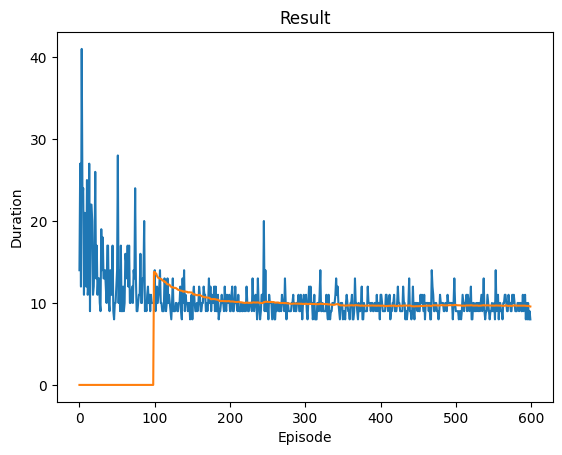

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()